# Greedy sensor location vs observability maximization

In [2]:
import numpy as np
from scipy.stats import multivariate_normal
from link_queue_model import *
from plot_density import *
from IMM_filter import *
from estimation_quality_eval import *

# Initialization

In [3]:
from itertools import combinations

def find_combinations(n, k):
    # Generate all combinations of k elements from a sequence of n elements
    all_combinations = list(combinations(range(n), k))
    return all_combinations

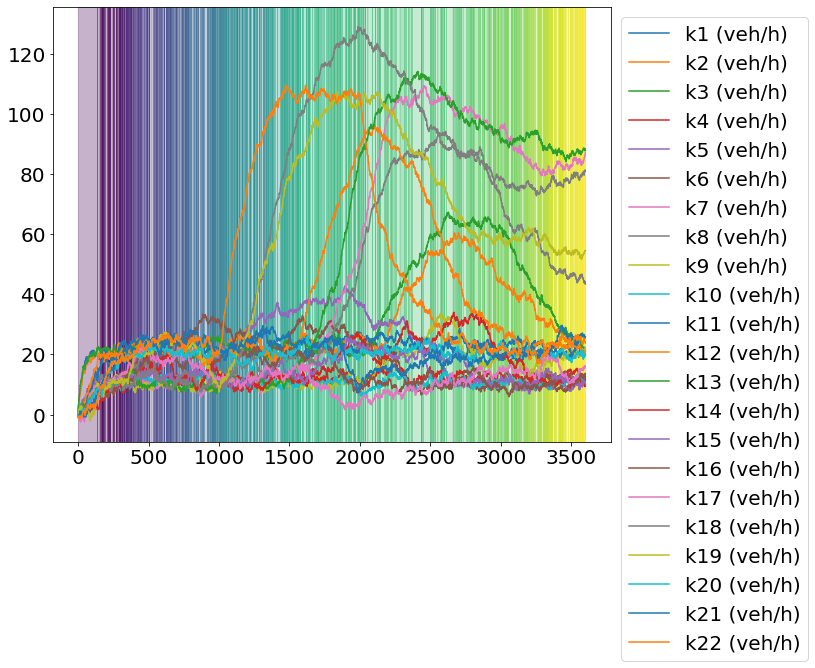

In [4]:
from example_initialization import initialize_22link

np.random.seed(10)

inflow_list, outflow_list, link_list, network_geometry, Q = initialize_22link()
density_list, boundary_list, A_list, u_list, mode_list, mode_transition_num, A_dict = LQM_matrix(inflow_list, outflow_list, network_geometry, link_list, Q, WITH_NOISE = True)
plot_density(density_list, mode_list)

# Without Noise

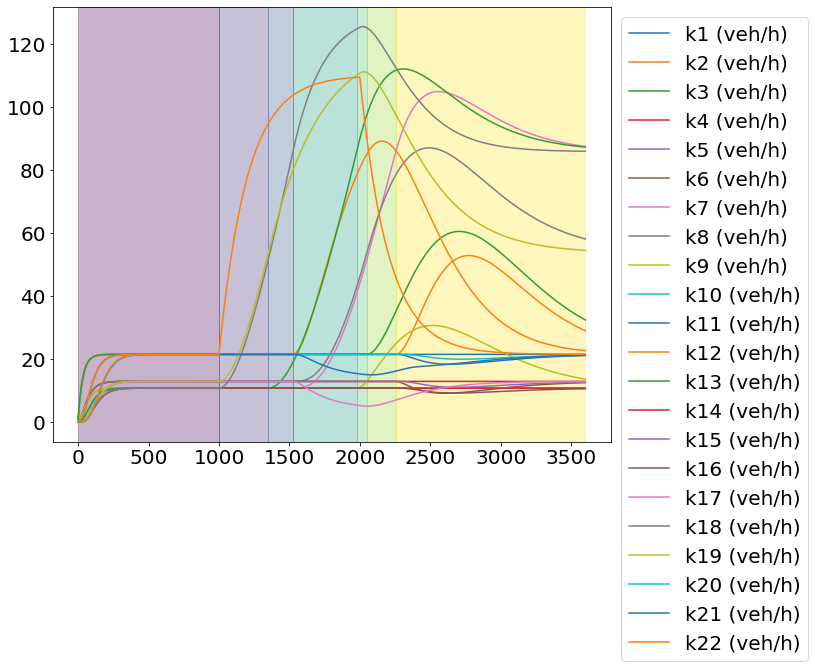

In [5]:
# density_list1, A_list1, u_list1, etc. are the noise-free counterpart
inflow_list, outflow_list, link_list, network_geometry, Q = initialize_22link()
density_list1, boundary_list1, A_list1, u_list1, mode_list1, mode_transition_num1, A_dict1 = LQM_matrix(inflow_list, outflow_list, network_geometry, link_list, Q, WITH_NOISE = False)
plot_density(density_list1, mode_list1)

# Estimation quality vs different sensor locations (Greedy vs Optimal Observability)


### Define greedy sensor placement
1. Observe the most variable links (among the 22 links, put sensors on top p most variable links)
2. Observe the links with the most flow
3. Maximize observability

In [18]:

def observability_score_22link_fast(C, w):
    # find number of reachable nodes in each graph
    obs_num_list=[((C@temp_matrix).sum(axis = 0)>0).sum() for temp_matrix in A_power_list]
    return (np.array(obs_num_list)*w).sum()

import numpy as np

def reachable_nodes(adj_matrix, sources):
    n = adj_matrix.shape[0]
    visited = np.zeros(n, dtype=bool)
    reachable = set()

    for source in sources:
        queue = [source]
        while queue:
            node = queue.pop(0)
            if not visited[node]:
                visited[node] = True
                reachable.add(node)
                neighbors = np.where(adj_matrix[node] > 0)[0]
                for neighbor in neighbors:
                    if not visited[neighbor]:
                        queue.append(neighbor)

    return len(list(reachable))

In [24]:
sensor_loc = all_comb[0]
sensor_loc

reachable_nodes(A_list[4], sensor_loc)

19

In [41]:
len(A_list)

585

In [49]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB

K = len(A_list)  # number of modes
p = 19  # number of sensors to place
n = 22  # number of total states

# Create a new model
model = gp.Model("sensor_placement")

# Define variables
z = model.addVars(n, vtype=GRB.BINARY, name="z")
x = model.addVars(K, n, vtype=GRB.BINARY, name="x")

# Convert A_list to binary adjacency matrices and normalize weights
A = []
for matrix in A_list:
    temp_matrix = np.zeros((n, n))
    temp_matrix[matrix > 0] = 1
    A.append(temp_matrix - np.diag(np.diagonal(temp_matrix)))
A = np.array(A)
w = np.array(list(A_dict.values())) / sum(A_dict.values())

# Define constraints
for k in range(K):
    # Constraint: sum of z must equal p
    model.addConstr(gp.quicksum(z[j] for j in range(n)) == p, f"sum_z_{k}")

    for j in range(n):
        # Constraint: x[k, j] <= 1
        model.addConstr(x[k, j] <= 1, f"x_leq_1_{k}_{j}")

        # Constraint: x[k, j] >= 0
        model.addConstr(x[k, j] >= 0, f"x_geq_0_{k}_{j}")

    for i in range(n):
        for j in range(n):
            # Constraint: x[k, j] <= A[k, i, j] * x[k, i] + z[j]
            model.addConstr(x[k, j] <= A[k, i, j] * x[k, i] + z[j], f"x_leq_A_{k}_{i}_{j}")

# Define objective function
objective = gp.quicksum(w[k] * gp.quicksum(x[k, j] for j in range(n)) for k in range(K))

# Set objective
model.setObjective(objective, GRB.MAXIMIZE)

# Optimize the model
model.optimize()

# Retrieve the results
z_values = model.getAttr('x', z)
x_values = model.getAttr('x', x)

print("Optimal sensor placement (z):")
print([z_values[i] for i in range(n)])

print("Optimal reachability (x):")
for k in range(K):
    print(f"Mode {k}: {[x_values[k, j] for j in range(n)]}")


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads



GurobiError: Model too large for size-limited license; visit https://www.gurobi.com/free-trial for a full license

In [ ]:
np.where(z.value>0)[0]+1

In [10]:
from numpy.linalg import matrix_power

A_power_list = []
n = 22
p = 19
T = 3600
all_comb = find_combinations(n, p)
w = np.fromiter(A_dict.values(), dtype=float)/sum(np.fromiter(A_dict.values(), dtype=float))

for temp_matrix in A_list:
    A_power_list.append(matrix_power(temp_matrix,n-1))


for sensor_loc in all_comb:
    counter+=1
    start = time.time()
    vect = np.zeros(n)
    vect[np.array(sensor_loc)] = 1
    C = np.diag(vect)[~np.all(np.diag(vect) == 0, axis=1)]

    y_k = list()
    for i in range(T):
        y_k.append(C@density_list[i])


    x_list, mu_list = IMM_filter(A_list1, u_list1, boundary_list1, PI, C, Q, y_k)
    obs_score = observability_score(A_list, C, w)
    observability_score_list.append(obs_score)
    
    MAPE = np.round(compute_error(x_list, density_list)*100, 4)
    MAPE_list.append(MAPE)
    print("Case", counter, '| MAPE (%) = ', MAPE, 'time(s) =', np.round(time.t

In [48]:
# sensor location optimization
import numpy as np
import pandas as pd
import cvxpy as cp

K = 585  # number of modes
p = 19  # number of sensors to place
n = 22  # number of total states

# define variables
z = cp.Variable(n, boolean=True)
x = cp.Variable((K, n))

A = []
for matrix in A_list:
    temp_matrix = np.zeros((22, 22))
    temp_matrix[matrix > 0] = 1
    A.append(temp_matrix - np.diag(np.diagonal(temp_matrix)))
A = np.array(A)
w = np.fromiter(A_dict.values(), dtype=float) / sum(np.fromiter(A_dict.values(), dtype=float))

# define constraints & objectives
constraints = []
ones = np.ones(n).reshape(n, 1)

# Ensure exactly p sensors
constraints += [cp.sum(z) == p]

for k in range(K):
    constraints += [x[k] >= 0]
    constraints += [x[k] <= 1]
    constraints += [x[k] <= (A[k].T) @ x[k] + z]

objective = cp.Maximize(w.T @ (x @ ones))

prob = cp.Problem(objective, constraints)
prob.solve()

# Print the results
print(f"Optimal sensor placement (z): {z.value}")
print(f"Objective value: {prob.value}")


SolverError: Solver 'GUROBI' failed. Try another solver, or solve with verbose=True for more information.

In [5]:
import time
n = 22
p = 19
T = 3600
all_comb = find_combinations(n, p)
PI = compute_PI(A_list1, mode_transition_num1)

MAPE_list = []
observability_score_list = []
counter = 0
w = np.fromiter(A_dict.values(), dtype=float)/sum(np.fromiter(A_dict.values(), dtype=float))


for sensor_loc in all_comb:
    counter+=1
    start = time.time()
    vect = np.zeros(n)
    vect[np.array(sensor_loc)] = 1
    C = np.diag(vect)[~np.all(np.diag(vect) == 0, axis=1)]

    y_k = list()
    for i in range(T):
        y_k.append(C@density_list[i])


    x_list, mu_list = IMM_filter(A_list1, u_list1, boundary_list1, PI, C, Q, y_k)
    obs_score = observability_score(A_list, C, w)
    observability_score_list.append(obs_score)
    
    MAPE = np.round(compute_error(x_list, density_list)*100, 4)
    MAPE_list.append(MAPE)
    print("Case", counter, '| MAPE (%) = ', MAPE, 'time(s) =', np.round(time.time()-start,2), "obs_num=", obs_score)

Case 1 | MAPE (%) =  162.239 time(s) = 29.64 obs_num= 20.558055555555555
Case 2 | MAPE (%) =  99.4567 time(s) = 24.33 obs_num= 20.81861111111111
Case 3 | MAPE (%) =  64.6094 time(s) = 27.66 obs_num= 20.6525
Case 4 | MAPE (%) =  162.3487 time(s) = 26.98 obs_num= 20.525555555555556
Case 5 | MAPE (%) =  99.3185 time(s) = 25.31 obs_num= 20.673611111111114
Case 6 | MAPE (%) =  64.4711 time(s) = 27.01 obs_num= 20.5075
Case 7 | MAPE (%) =  162.4306 time(s) = 29.25 obs_num= 20.326666666666668
Case 8 | MAPE (%) =  4.5189 time(s) = 26.39 obs_num= 20.519166666666667
Case 9 | MAPE (%) =  99.379 time(s) = 25.9 obs_num= 20.704722222222223
Case 10 | MAPE (%) =  64.5316 time(s) = 25.36 obs_num= 20.538611111111113
Case 11 | MAPE (%) =  84.5595 time(s) = 26.66 obs_num= 20.413055555555555
Case 12 | MAPE (%) =  65.2099 time(s) = 26.7 obs_num= 20.681944444444444
Case 13 | MAPE (%) =  147.4846 time(s) = 25.68 obs_num= 19.941111111111113
Case 14 | MAPE (%) =  2.4284 time(s) = 39.34 obs_num= 20.94250000000000

KeyboardInterrupt: 

In [7]:
len(MAPE_list)

77

In [20]:
    sensor_loc = all_comb[0]
    counter+=1
    start = time.time()
    vect = np.zeros(n)
    vect[np.array(sensor_loc)] = 1
    C = np.diag(vect)[~np.all(np.diag(vect) == 0, axis=1)]

    y_k = list()
    for i in range(T):
        y_k.append(C@density_list[i])


    x_list, mu_list = IMM_filter(A_list1, u_list1, boundary_list1, PI, C, Q, y_k)
    obs_score = observability_score(A_list, C, w)
    observability_score_list.append(obs_score)
    
    MAPE = np.round(compute_error(x_list, density_list)*100, 4)
    MAPE_list.append(MAPE)
    print("Case", counter, '| MAPE (%) = ', MAPE, 'time(s) =', np.round(time.time()-start,2), "obs_num=", obs_score)

Case 3 | MAPE (%) =  162.239 time(s) = 50.97 obs_num= 20.558055555555555


In [22]:
x_list[-1]

array([[ 21.53025922],
       [ 20.21715607],
       [ 21.29364516],
       [ 12.50125941],
       [ 10.08932368],
       [ 13.62416622],
       [ 87.15067046],
       [ 43.43703005],
       [ 22.42354668],
       [ 10.25965174],
       [ 19.81653267],
       [ 20.89376551],
       [ 87.80232108],
       [  9.4444575 ],
       [ 11.89515123],
       [ 11.46664091],
       [ 15.52761551],
       [ 81.07743406],
       [ 54.56989156],
       [831.53122484],
       [666.04917475],
       [ 20.77410416]])

In [ ]:
# get the mode frequency based on the actual mode occurrence
w = np.fromiter(A_dict.values(), dtype=float)/sum(np.fromiter(A_dict.values(), dtype=float))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(10, 5)) 
plt.scatter(observability_score_list, MAPE_list, alpha=0.4)
plt.title("MAPE vs observability")
plt.xlabel("Number of observable components")
plt.ylabel("MAPE(%)")
plt.show()

In [ ]:
bin_num = int((max(observability_score_list)-min(observability_score_list))//1+1)
bin_x = [None] * bin_num
bin_data = [None] * bin_num

for i in range(bin_num):
    bin_start = min(observability_score_list) + 1*i
    bin_end = min(observability_score_list) + 1*(i+1)
    bin_x[i] = str(bin_start)+'~'+str(bin_end)
    bin_data[i] = np.array(MAPE_list)[(np.array(observability_score_list)>bin_start) 
                                      & (np.array(observability_score_list)<bin_end)]
    
    

In [ ]:
bin_x

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
 
 
# Creating dataset
np.random.seed(10)
 
fig = plt.figure(figsize =(15, 7))
plt.boxplot(bin_data)

plt.xticks([1, 2, 3, 4, 5, 6], bin_x)
plt.xlabel("observability")
plt.ylabel("Estimation MAPE (%)")

# show plot
plt.show()

In [ ]:
MAPE_list_reduced = np.array(MAPE_list)[np.array(MAPE_list)<100]
observablity_score_list_reduced = np.array(observablity_score_list)[np.array(MAPE_list)<100]
plt.figure(figsize=(10, 5)) 
plt.scatter(observablity_score_list_reduced, MAPE_list_reduced, alpha=0.4)
plt.title("MAPE vs observability")
plt.xlabel("Number of observable components")
plt.ylabel("MAPE(%)")
plt.show()

In [ ]:
bin_num = int((max(observablity_score_list)-min(observablity_score_list))//0.5+1)
bin_x1 = [None] * bin_num
bin_data1 = [None] * bin_num

for i in range(bin_num):
    bin_start = min(observablity_score_list) + 0.5*i
    bin_end = min(observablity_score_list) + 0.5*(i+1)
    bin_x1[i] = str(bin_start)+'~'+str(bin_end)
    bin_data1[i] = MAPE_list_reduced[(np.array(observablity_score_list_reduced)>bin_start) 
                                      & (np.array(observablity_score_list_reduced)<bin_end)]
    
    

In [ ]:
import pandas as pd
df = pd.DataFrame({
    'sensor_loc': all_comb_18,
    'MAPE': MAPE_list_18
})

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
 
 
# Creating dataset
np.random.seed(10)
 
fig = plt.figure(figsize =(15, 7))
plt.boxplot(bin_data1)

plt.xticks([1, 2, 3, 4, 5, 6], bin_x1)
plt.xlabel("observability")
plt.ylabel("Estimation MAPE (%)")

# show plot
plt.show()

In [ ]:
import time
n = 22
p = 18
all_comb_18 = find_combinations(n, p)
PI = compute_PI(A_list1, mode_transition_num1)

MAPE_list_18 = []
observablity_score_list_18 = []
counter = 0
for sensor_loc in all_comb_18:
    counter+=1
    if counter % 73 ==0: 
        print('----------------------', counter//73,"%","-----------------------")
    start = time.time()
    vect = np.zeros(n)
    vect[np.array(sensor_loc)]  = 1
    C = np.diag(vect)[~np.all(np.diag(vect) == 0, axis=1)]

    y_k = list()
    for i in range(T):
        y_k.append(C@density_list[i])

    x_list, mu_list = IMM_filter_reduced(A_list1,PI)
    obs_score_18 = observablity_score(A_list, C, w)
    observablity_score_list_18.append(obs_score)
    
    MAPE = np.round(compute_error(x_list, density_list)*100, 4)
    MAPE_list_18.append(MAPE)
    print("Case", counter, '| MAPE (%) = ', MAPE, 'time(s) =', np.round(time.time()-start,2), "obs_num=", obs_score)

In [ ]:
import pandas as pd
df = pd.DataFrame({
    'sensor_loc': all_comb_18,
    'MAPE': MAPE_list_18
})

In [ ]:
df.to_csv("18sensors.csv")

In [ ]:

observablity_score_list_18 = []
for sensor_loc in all_comb_18:
    vect = np.zeros(n)
    vect[np.array(sensor_loc)]  = 1
    C = np.diag(vect)[~np.all(np.diag(vect) == 0, axis=1)]

    obs_score_18 = observablity_score(A_list, C, w)
    observablity_score_list_18.append(obs_score_18)
    

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5)) 
plt.scatter(observablity_score_list_18, MAPE_list_18, alpha=0.4)
plt.title("MAPE vs observability")
plt.xlabel("Number of observable components")
plt.ylabel("MAPE(%)")
plt.show()

In [ ]:
bin_num = int((max(observablity_score_list_18)-min(observablity_score_list_18))//1+1)
bin_x = [None] * bin_num
bin_data = [None] * bin_num

for i in range(bin_num):
    bin_start = min(observablity_score_list_18) + i
    bin_end = min(observablity_score_list_18) + (i+1)
    bin_x[i] = str(bin_start)+'~'+str(bin_end)
    bin_data[i] = np.array(MAPE_list_18)[(np.array(observablity_score_list_18)>bin_start) 
                                      & (np.array(observablity_score_list_18)<bin_end)]
    
fig = plt.figure(figsize =(15, 7))
plt.boxplot(bin_data)

plt.xticks(list(np.arange(bin_num)+1), bin_x)
plt.xlabel("observability")
plt.ylabel("Estimation MAPE (%)")

# show plot
plt.show()    

In [ ]:
bin_data[7]

In [ ]:
df["Observability"] = observablity_score_list_18

In [ ]:
df.to_csv("18sensors.csv")

In [ ]:
np.where(np.array(MAPE_list_18)==max(MAPE_list_18))


In [ ]:
max(MAPE_list_18)

In [ ]:
    PI = compute_PI(A_list1, mode_transition_num1)

    sensor_loc = (0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21)
    vect = np.zeros(n)
    vect[np.array(sensor_loc)]  = 1
    C = np.diag(vect)[~np.all(np.diag(vect) == 0, axis=1)]

    y_k = list()
    for i in range(T):
        y_k.append(C@density_list[i])

    x_list, mu_list = IMM_filter_reduced(A_list1,PI)
    obs_score_18 = observablity_score(A_list, C, w)
    
    print(compute_error(x_list, density_list))

In [ ]:
print(compute_error(x_list, density_list))

In [ ]:
plot_2densities(x_list, density_list)

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
plt.figure(figsize=(10,8), dpi=200)

G = nx.DiGraph() 

adjacent = A

for i in range(22): 
    for j in range(22): 
        if adjacent[i][j] != 0: 
            G.add_edge(i,j) 
            

pos = nx.planar_layout(G,scale=0.2)

mapping = {}
for i in range(22):
    mapping[i] = i+1
mapping
G = nx.relabel_nodes(G, mapping)
pos[1] = [0.09090909,1]
pos[2] = [0.45454545,1]
pos[3] = [0.81818182,1]
pos[4] = [0, 0.75]
pos[5] = [0.18181818, 0.75]
pos[6] = [0.36363636, 0.75]
pos[7] = [0.54545455, 0.75]
pos[8] = [0.72727273, 0.75]
pos[9] = [0.90909091, 0.75]

pos[10]  = [-0.09090909, 0.5]
pos[11] = [0.27272727, 0.5]
pos[12] = [0.63636364, 0.5]
pos[13] = [1, 0.5]

pos[14] = [0, 0.25]
pos[15] = [0.18181818, 0.25]
pos[16] = [0.36363636, 0.25]
pos[17] = [0.54545455, 0.25]
pos[18] = [0.72727273, 0.25]
pos[19] = [0.90909091, 0.25]

pos[20] = [0.09090909,0]
pos[21] = [0.45454545,0]
pos[22] = [0.81818182,0]



nx.draw(G, pos,with_labels = True, node_size = 1200,node_color="black",
        width=2, font_color='white',font_size=22, arrowsize=25) 

plt.show() 

In [ ]:
# sensor location optimization
import numpy as np
import pandas as pd
import cvxpy as cp
K = 8 # number of modes
p = 4# number of sensors to place
n = 22 # number of total states
# define variables
z = cp.Variable(n, boolean=True)
x = cp.Variable((K,n))

In [ ]:
A = []
for matrix in A_list1:
    temp_matrix = np.zeros((22,22))
    temp_matrix[matrix>0] =1 
    A.append(temp_matrix - np.diag(np.diagonal(temp_matrix)))
A = np.array(A)
w = np.fromiter(A_dict1.values(), dtype=float)/sum(np.fromiter(A_dict.values(), dtype=float))

In [ ]:
# define constraints & objectives
constraints = []
ones = np.ones(n).reshape(n,1)
for k in range(K):
    constraints += [ones.T @ z >= p, ones.T @ z <= p]
    constraints += [z<=1]
    constraints += [z>=0]
    constraints += [x[k]>=0]
    
    #constraints += [x[k]>=z]
    constraints += [x[k]<=1]
    #constraints += [A_start[k]@x[k] <= A_end[k]@x[k]]
    constraints += [x[k] <= (A[k].T)@x[k] + z]
constraints += [z>=np.array([0., 0, 0., 0., 0., 0., 0., 0., 0, 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0, 0, 0.])]
# constraints += [z<=np.array([0., 0, 0., 0., 0., 0., 0., 0., 0, 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0, 0, 0.])]

objective = cp.Maximize(w.T@(x@ones))

In [ ]:
prob = cp.Problem(objective, constraints)
prob.solve()

In [ ]:
x_opt = x.value
w_opt = (x_opt * w.reshape(8,1).round(2)).sum(axis = 0)

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
plt.figure(figsize=(10,8), dpi=200)

G = nx.DiGraph() 

adjacent = A_list[12]

for i in range(22): 
    for j in range(22): 
        if adjacent[i][j] != 0: 
            G.add_edge(i,j) 
            

pos = nx.planar_layout(G,scale=0.2)

mapping = {}
for i in range(22):
    mapping[i] = i+1
mapping
G = nx.relabel_nodes(G, mapping)
pos[1] = [0.09090909,1]
pos[2] = [0.45454545,1]
pos[3] = [0.81818182,1]
pos[4] = [0, 0.75]
pos[5] = [0.18181818, 0.75]
pos[6] = [0.36363636, 0.75]
pos[7] = [0.54545455, 0.75]
pos[8] = [0.72727273, 0.75]
pos[9] = [0.90909091, 0.75]

pos[10]  = [-0.09090909, 0.5]
pos[11] = [0.27272727, 0.5]
pos[12] = [0.63636364, 0.5]
pos[13] = [1, 0.5]

pos[14] = [0, 0.25]
pos[15] = [0.18181818, 0.25]
pos[16] = [0.36363636, 0.25]
pos[17] = [0.54545455, 0.25]
pos[18] = [0.72727273, 0.25]
pos[19] = [0.90909091, 0.25]

pos[20] = [0.09090909,0]
pos[21] = [0.45454545,0]
pos[22] = [0.81818182,0]



nx.draw(G, pos,with_labels = True, node_size = 1200,node_color="black",
        width=2, font_color='white',font_size=22, arrowsize=25) 

plt.show() 

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
plt.figure(figsize=(10,8), dpi=200)

G = nx.DiGraph() 

adjacent = A_list[12]

for i in range(22): 
    for j in range(22): 
        if adjacent[i][j] != 0: 
            G.add_edge(i,j) 
            

pos = nx.planar_layout(G,scale=0.2)

mapping = {}
for i in range(22):
    mapping[i] = i+1
mapping
G = nx.relabel_nodes(G, mapping)
pos[1] = [0.09090909,1]
pos[2] = [0.45454545,1]
pos[3] = [0.81818182,1]
pos[4] = [0, 0.75]
pos[5] = [0.18181818, 0.75]
pos[6] = [0.36363636, 0.75]
pos[7] = [0.54545455, 0.75]
pos[8] = [0.72727273, 0.75]
pos[9] = [0.90909091, 0.75]

pos[10]  = [-0.09090909, 0.5]
pos[11] = [0.27272727, 0.5]
pos[12] = [0.63636364, 0.5]
pos[13] = [1, 0.5]

pos[14] = [0, 0.25]
pos[15] = [0.18181818, 0.25]
pos[16] = [0.36363636, 0.25]
pos[17] = [0.54545455, 0.25]
pos[18] = [0.72727273, 0.25]
pos[19] = [0.90909091, 0.25]

pos[20] = [0.09090909,0]
pos[21] = [0.45454545,0]
pos[22] = [0.81818182,0]



nx.draw(G, pos,with_labels = True, node_size = 1200,node_color="black",
        width=2, font_color='white',font_size=22, arrowsize=25) 

plt.show() 

In [ ]:
G = nx.DiGraph() 
graph_links = [(1,4),(2,5),(3,6),(4,7),(4,8),(5,8),(5,9),(6,9),(6,10),(7,11),(8,12),(9,13),(10,14),
              (11,15),(12,15),(12,16),(13,16),(13,17),(14,17),(15,18),(16,19),(17,20)]
for i,j in graph_links: 
    G.add_edge(i,j) 
            
pos = nx.planar_layout(G,scale=0.2)
pos[1] = [1,6.2]
pos[2] = [3,6.2]
pos[3] = [5,6.2]
pos[4] = [1,4.8]
pos[5] = [3,4.8]
pos[6] = [5,4.8]
pos[7] = [0, 3.8]
pos[8] = [2, 3.8]
pos[9] = [4, 3.8]
pos[10]  = [6, 3.8]

pos[11] = [0, 2.4]
pos[12] = [2, 2.4]
pos[13] = [4, 2.4]
pos[14] = [6, 2.4]

pos[15] = [1, 1.4]
pos[16] = [3, 1.4]
pos[17] = [5, 1.4]

pos[18] = [1, 0]
pos[19] = [3, 0]
pos[20] = [5, 0]

edge_labels = {
    (1,4):1,(2,5):2,(3,6):3,
    (4,7):4,(4,8):5,(5,8):6,(5,9):7,(6,9):8,(6,10):9,
    (7,11):10,(8,12):11,(9,13):12,(10,14):13,
    (11,15):14,(12,15):15,(12,16):16,(13,16):17,(13,17):18,(14,17):19,
    (15,18):20,(16,19):21,(17,20):22
}

# myKeys = list(pos.keys())
# myKeys.sort()
# sorted_dict = {i: pos[i] for i in myKeys}
# pos = sorted_dict

plt.figure(figsize=(30,30), dpi=200)
nx.draw(G, pos,width = 6, with_labels = False, node_size = 0, arrowsize=50) 
nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels,font_size=45,rotate =False,clip_on=False)
plt.show() 

In [ ]:
edges = G.edges()
reorder_index_list = [edge_labels[(u,v)] for u,v in edges]


In [ ]:
import matplotlib
plt.figure(figsize=(10,8), dpi=200)
cmap = matplotlib.cm.get_cmap('summer_r')
GnRd = colors.LinearSegmentedColormap('GnRd', cdict)
nx.draw(G, pos,with_labels = False,width=3, node_size = 0,edge_cmap=cmap,edge_color =w_opt) 
# nx.draw_networkx_edge_labels(G, pos, edge_labels = dict(zip(list(edge_labels),w_opt.round(2))))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm)

In [ ]:
# sensor location optimization
import numpy as np
import pandas as pd
import cvxpy as cp
K = 8 # number of modes
p = 4# number of sensors to place
n = 22 # number of total states
# define variables
z = cp.Variable(n, boolean=True)
x = cp.Variable((K,n))

A = []
for matrix in A_list1:
    temp_matrix = np.zeros((22,22))
    temp_matrix[matrix>0] =1 
    A.append(temp_matrix - np.diag(np.diagonal(temp_matrix)))
A = np.array(A)
w = np.fromiter(A_dict1.values(), dtype=float)/sum(np.fromiter(A_dict.values(), dtype=float))

# define constraints & objectives
constraints = []
ones = np.ones(n).reshape(n,1)
for k in range(K):
    constraints += [ones.T @ z >= p, ones.T @ z <= p]
    constraints += [z<=1]
    constraints += [z>=0]
    constraints += [x[k]>=0]
    
    #constraints += [x[k]>=z]
    constraints += [x[k]<=1]
    #constraints += [A_start[k]@x[k] <= A_end[k]@x[k]]
    constraints += [x[k] <= (A[k].T)@x[k] + z]
# constraints += [z>=np.array([0., 0, 0., 0., 0., 0., 0., 0., 0, 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0, 0, 0.])]
# constraints += [z<=np.array([0., 0, 0., 0., 0., 0., 0., 0., 0, 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0, 0, 0.])]

objective = cp.Maximize(w.T@(x@ones))

prob = cp.Problem(objective, constraints)
prob.solve()

z.value

In [ ]:
np.where(z.value>0)

In [ ]:
w_opt

In [ ]:
x_opt = x.value
w_opt = np.zeros(22)
w_unordered = (x_opt * w.reshape(8,1)).sum(axis = 0)
edges = G.edges()
reorder_index_list = [edge_labels[(u,v)] for u,v in edges]
for i,index in enumerate(reorder_index_list):
    w_opt[i] = w_unordered[index-1]


import matplotlib
plt.figure(figsize=(10,8), dpi=200)
cmap = matplotlib.cm.get_cmap('summer_r')
GnRd = colors.LinearSegmentedColormap('GnRd', cdict)

nx.draw(G, pos,with_labels = False,width=3, node_size = 0,edge_cmap=cmap,edge_color =w_opt) 
# nx.draw_networkx_edge_labels(G, pos, edge_labels = dict(zip(list(edge_labels),w_opt.round(2))))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm)

In [ ]:
w_opt

In [ ]:
z.value

## Find best sensor location for 16, 17, 18, 19


In [ ]:
# sensor location optimization
import numpy as np
import pandas as pd
import cvxpy as cp
K = 585 # number of modes
p = 16# number of sensors to place
n = 22 # number of total states
# define variables
z = cp.Variable(n, boolean=True)
x = cp.Variable((K,n))

A = []
for matrix in A_list:
    temp_matrix = np.zeros((22,22))
    temp_matrix[matrix>0] =1 
    A.append(temp_matrix - np.diag(np.diagonal(temp_matrix)))
A = np.array(A)
w = np.fromiter(A_dict.values(), dtype=float)/sum(np.fromiter(A_dict.values(), dtype=float))

# define constraints & objectives
constraints = []
ones = np.ones(n).reshape(n,1)
for k in range(K):
    constraints += [ones.T @ z >= p, ones.T @ z <= p]
    constraints += [z<=1]
    constraints += [z>=0]
    constraints += [x[k]>=0]
    
    #constraints += [x[k]>=z]
    constraints += [x[k]<=1]
    #constraints += [A_start[k]@x[k] <= A_end[k]@x[k]]
    constraints += [x[k] <= (A[k].T)@x[k] + z]
# constraints += [z>=np.array([0., 0, 0., 0., 0., 0., 0., 0., 0, 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0, 0, 0.])]
# constraints += [z<=np.array([0., 0, 0., 0., 0., 0., 0., 0., 0, 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0, 0, 0.])]

objective = cp.Maximize(w.T@(x@ones))

prob = cp.Problem(objective, constraints)
prob.solve()

In [ ]:
np.where(z.value>0)[0]+1

In [ ]:
PI = compute_PI(A_list1, mode_transition_num1)
vect = z.value
C = np.diag(vect)[~np.all(np.diag(vect) == 0, axis=1)]

y_k = list()
for i in range(T):
    y_k.append(C@density_list[i])

x_list, mu_list = IMM_filter_reduced(A_list1,PI)
obs_score = observability_score(A_list, C, w)

MAPE = np.round(compute_error(x_list, density_list)*100, 4)
print("Case", 1, '| MAPE (%) = ', MAPE,  "obs_num=", obs_score)

In [ ]:
#17

# sensor location optimization
import numpy as np
import pandas as pd
import cvxpy as cp
K = 585 # number of modes
p = 17# number of sensors to place
n = 22 # number of total states
# define variables
z = cp.Variable(n, boolean=True)
x = cp.Variable((K,n))

A = []
for matrix in A_list:
    temp_matrix = np.zeros((22,22))
    temp_matrix[matrix>0] =1 
    A.append(temp_matrix - np.diag(np.diagonal(temp_matrix)))
A = np.array(A)
w = np.fromiter(A_dict.values(), dtype=float)/sum(np.fromiter(A_dict.values(), dtype=float))

# define constraints & objectives
constraints = []
ones = np.ones(n).reshape(n,1)
for k in range(K):
    constraints += [ones.T @ z >= p, ones.T @ z <= p]
    constraints += [z<=1]
    constraints += [z>=0]
    constraints += [x[k]>=0]
    
    #constraints += [x[k]>=z]
    constraints += [x[k]<=1]
    #constraints += [A_start[k]@x[k] <= A_end[k]@x[k]]
    constraints += [x[k] <= (A[k].T)@x[k] + z]
# constraints += [z>=np.array([0., 0, 0., 0., 0., 0., 0., 0., 0, 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0, 0, 0.])]
# constraints += [z<=np.array([0., 0, 0., 0., 0., 0., 0., 0., 0, 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0, 0, 0.])]

objective = cp.Maximize(w.T@(x@ones))

prob = cp.Problem(objective, constraints)
prob.solve()

In [ ]:
np.where(z.value>0)[0]+1

In [ ]:
PI = compute_PI(A_list1, mode_transition_num1)
vect = z.value
C = np.diag(vect)[~np.all(np.diag(vect) == 0, axis=1)]

y_k = list()
for i in range(T):
    y_k.append(C@density_list[i])

x_list, mu_list = IMM_filter_reduced(A_list1,PI)
obs_score = observability_score(A_list, C, w)

MAPE = np.round(compute_error(x_list, density_list)*100, 4)
print("Case", 2, '| MAPE (%) = ', MAPE,  "obs_num=", obs_score)

In [ ]:
#18

# sensor location optimization
import numpy as np
import pandas as pd
import cvxpy as cp
K = 585 # number of modes
p = 18# number of sensors to place
n = 22 # number of total states
# define variables
z = cp.Variable(n, boolean=True)
x = cp.Variable((K,n))

A = []
for matrix in A_list:
    temp_matrix = np.zeros((22,22))
    temp_matrix[matrix>0] =1 
    A.append(temp_matrix - np.diag(np.diagonal(temp_matrix)))
A = np.array(A)
w = np.fromiter(A_dict.values(), dtype=float)/sum(np.fromiter(A_dict.values(), dtype=float))

# define constraints & objectives
constraints = []
ones = np.ones(n).reshape(n,1)
for k in range(K):
    constraints += [ones.T @ z >= p, ones.T @ z <= p]
    constraints += [z<=1]
    constraints += [z>=0]
    constraints += [x[k]>=0]
    
    #constraints += [x[k]>=z]
    constraints += [x[k]<=1]
    #constraints += [A_start[k]@x[k] <= A_end[k]@x[k]]
    constraints += [x[k] <= (A[k].T)@x[k] + z]
# constraints += [z>=np.array([0., 0, 0., 0., 0., 0., 0., 0., 0, 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0, 0, 0.])]
# constraints += [z<=np.array([0., 0, 0., 0., 0., 0., 0., 0., 0, 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0, 0, 0.])]

objective = cp.Maximize(w.T@(x@ones))

prob = cp.Problem(objective, constraints)
prob.solve()

In [ ]:
np.where(z.value>0)[0]+1

In [ ]:
PI = compute_PI(A_list1, mode_transition_num1)
vect = z.value
C = np.diag(vect)[~np.all(np.diag(vect) == 0, axis=1)]

y_k = list()
for i in range(T):
    y_k.append(C@density_list[i])

x_list, mu_list = IMM_filter_reduced(A_list1,PI)
obs_score = observability_score(A_list, C, w)

MAPE = np.round(compute_error(x_list, density_list)*100, 4)
print("Case", 2, '| MAPE (%) = ', MAPE,  "obs_num=", obs_score)

In [ ]:
#19

# sensor location optimization
import numpy as np
import pandas as pd
import cvxpy as cp
K = 585 # number of modes
p = 19# number of sensors to place
n = 22 # number of total states
# define variables
z = cp.Variable(n, boolean=True)
x = cp.Variable((K,n))

A = []
for matrix in A_list:
    temp_matrix = np.zeros((22,22))
    temp_matrix[matrix>0] =1 
    A.append(temp_matrix - np.diag(np.diagonal(temp_matrix)))
A = np.array(A)
w = np.fromiter(A_dict.values(), dtype=float)/sum(np.fromiter(A_dict.values(), dtype=float))

# define constraints & objectives
constraints = []
ones = np.ones(n).reshape(n,1)
for k in range(K):
    constraints += [ones.T @ z >= p, ones.T @ z <= p]
    constraints += [z<=1]
    constraints += [z>=0]
    constraints += [x[k]>=0]
    
    #constraints += [x[k]>=z]
    constraints += [x[k]<=1]
    #constraints += [A_start[k]@x[k] <= A_end[k]@x[k]]
    constraints += [x[k] <= (A[k].T)@x[k] + z]
# constraints += [z>=np.array([0., 0, 0., 0., 0., 0., 0., 0., 0, 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0, 0, 0.])]
# constraints += [z<=np.array([0., 0, 0., 0., 0., 0., 0., 0., 0, 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0, 0, 0.])]

objective = cp.Maximize(w.T@(x@ones))

prob = cp.Problem(objective, constraints)
prob.solve()

In [ ]:
np.where(z.value>0)[0]+1

In [ ]:
PI = compute_PI(A_list1, mode_transition_num1)
vect = z.value
C = np.diag(vect)[~np.all(np.diag(vect) == 0, axis=1)]

y_k = list()
for i in range(T):
    y_k.append(C@density_list[i])

x_list, mu_list = IMM_filter_reduced(A_list1,PI)
obs_score = observability_score(A_list, C, w)

MAPE = np.round(compute_error(x_list, density_list)*100, 4)
print("Case", 2, '| MAPE (%) = ', MAPE,  "obs_num=", obs_score)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data = np.random.randn(100)

# Create a box plot
plt.boxplot(data)

# Add a red dashed line at y=2
plt.axhline(y=2, color='red', linestyle='--')

# Show the plot
plt.show()

In [ ]:
pos

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors

# Create a random graph
G = nx.gnp_random_graph(10, 0.3)

# Assign random weights to the edges
edge_weights = np.random.rand(len(G.edges()))

# Set up the positions of the nodes (spring layout for simplicity)
pos = nx.spring_layout(G)

# Create a figure and axis
plt.figure(figsize=(8, 6), dpi=200)

# Define a colormap
cmap = plt.cm.get_cmap('viridis')

# Normalize edge weights to be in the range [0, 1] for colormap
norm_edge_weights = (edge_weights - np.min(edge_weights)) / (np.max(edge_weights) - np.min(edge_weights))

# Draw the graph with colored edges
nx.draw(G, pos, with_labels=True, width=3, node_size=300, edge_color=norm_edge_weights, edge_cmap=cmap)

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.min(edge_weights), vmax=np.max(edge_weights)))
sm.set_array([])
cbar = plt.colorbar(sm, label='Edge Weights')

# Show the plot
plt.show()

In [ ]:
A[409]